In [1]:
import torch
import torchvision

In [2]:
n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [58]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.CenterCrop(16),
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0), (1/255))
                             ])),
  batch_size=batch_size_train, shuffle=True)

#torchvision.transforms.Normalize(
#                                 (0.1307,), (0.3081,))

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.CenterCrop(16),
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0), (1/255))
                             ])),
  batch_size=batch_size_test, shuffle=True)

In [59]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
example_data.shape

torch.Size([1000, 1, 16, 16])

In [61]:
print(example_data[1][0])

tensor([[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
          24.0000,  92.0000, 177.0000, 242.0000, 254.0000, 254.0000, 254.0000,
         254.0000, 227.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,  24.0000, 156.0000,
         238.0000, 254.0000, 254.0000, 254.0000, 254.0000, 254.0000, 244.0000,
         158.0000,  41.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   7.0000, 138.0000, 254.0000,
         254.0000, 254.0000, 254.0000, 254.0000, 228.0000, 161.0000,  41.0000,
           0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000, 121.0000, 254.0000, 254.0000,
         254.0000, 254.0000, 192.0000, 107.0000,  18.0000,   0.0000,   0.0000,
           0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,  29.0000, 230.0000, 254.0000, 237.0000,
          76.0000,  52.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000],
        [  0.0000,   0.0000,  28.0000, 213.0000, 254.0000, 2

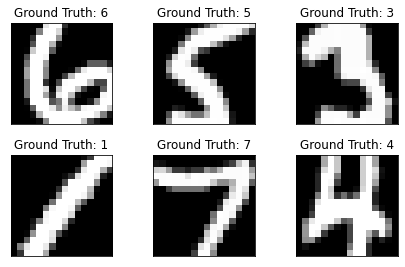

In [62]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])

In [63]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [64]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        #self.fc1 = nn.Linear(28*28, 16)
        self.fc1 = nn.Linear(16*16, 8)
        #self.fc2 = nn.Linear(16, 16)
        self.fc3 = nn.Linear(8, 10)

    def forward(self, x):
        x = x.view(-1,16*16)
        x = F.relu(self.fc1(x))
        #x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x)

In [65]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)

In [66]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [67]:
def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      torch.save(network.state_dict(), './model.pth')
      torch.save(optimizer.state_dict(), './optimizer.pth')

In [68]:
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [ ]:
test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

<ipython-input-64-759eb957afec>:14: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)



Test set: Avg. loss: 89.5804, Accuracy: 997/10000 (10%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 93.347130
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.322316
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.339863
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.340613
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.345960
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.276436
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.303554
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.301215
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.301728
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.301901
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.340504
Train Epoch: 1 [7040/60000 (12%)]	Loss: 2.314547
Train Epoch: 1 [7680/60000 (13%)]	Loss: 2.305613
Train Epoch: 1 [8320/60000 (14%)]	Loss: 2.290804
Train Epoch: 1 [8960/60000 (15%)]	Loss: 2.290533
Train Epoch: 1 [9600/60000 (16%)]	Loss: 2.305450
Train Epoch: 1 [10240/60000 (17%)]	Loss: 2.329065
Train Epoch: 1 [10880/60000 (18%)]	Loss: 2.314019
Train Epoch: 1 [11520/60000 (19%)]	Loss: 2.301218
Train Epoch: 1 [1216

Train Epoch: 2 [44800/60000 (75%)]	Loss: 2.293767
Train Epoch: 2 [45440/60000 (76%)]	Loss: 2.300991
Train Epoch: 2 [46080/60000 (77%)]	Loss: 2.309206
Train Epoch: 2 [46720/60000 (78%)]	Loss: 2.302672
Train Epoch: 2 [47360/60000 (79%)]	Loss: 2.296992
Train Epoch: 2 [48000/60000 (80%)]	Loss: 2.302927
Train Epoch: 2 [48640/60000 (81%)]	Loss: 2.312102
Train Epoch: 2 [49280/60000 (82%)]	Loss: 2.297254
Train Epoch: 2 [49920/60000 (83%)]	Loss: 2.300515
Train Epoch: 2 [50560/60000 (84%)]	Loss: 2.299320
Train Epoch: 2 [51200/60000 (85%)]	Loss: 2.299796
Train Epoch: 2 [51840/60000 (86%)]	Loss: 2.292823
Train Epoch: 2 [52480/60000 (87%)]	Loss: 2.306822
Train Epoch: 2 [53120/60000 (88%)]	Loss: 2.296274
Train Epoch: 2 [53760/60000 (90%)]	Loss: 2.306001
Train Epoch: 2 [54400/60000 (91%)]	Loss: 2.298429
Train Epoch: 2 [55040/60000 (92%)]	Loss: 2.295592
Train Epoch: 2 [55680/60000 (93%)]	Loss: 2.301939
Train Epoch: 2 [56320/60000 (94%)]	Loss: 2.302105
Train Epoch: 2 [56960/60000 (95%)]	Loss: 2.307983
